In [1]:
import multiprocessing as mp
import time
from typing import Any, Generator, Literal

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models as torch_model
import seaborn as sns

%matplotlib inline


# Train loop

In [2]:
class Trainer(object):
    def __init__(
        self,
        model: nn.Module,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        optimizer: Any,
        loss: Any,
        device: Literal["cuda", "cpu"],
    ) -> None:
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.optimizer = optimizer
        self.loss = loss
        self.device = device

    def _train_loop(self) -> float:
        self.model.train()

        corrects_quantity = 0
        total = 0

        for images, labels in self.train_dataloader:
            self.optimizer.zero_grad()

            images = images.type(torch.float32)
            images = images.to(self.device)
            labels = labels.to(self.device)

            preds = self.model(images)

            loss = self.loss(
                preds.type(torch.float32),
                F.one_hot(labels, num_classes=10).type(torch.float32),
            )

            corrects = labels == preds.argmax(dim=1)
            corrects_quantity += int(corrects.sum())

            loss.backward()
            self.optimizer.step()
            total += len(preds)

        return corrects_quantity / total

    def _test_loop(self) -> float:
        self.model.eval()
        corrects_quantity = 0
        total = 0

        with torch.no_grad():
            for images, labels in self.test_dataloader:
                self.optimizer.zero_grad()

                images = images.type(torch.float32)

                images = images.to(self.device)
                labels = labels.to(self.device)

                preds = self.model(images)

                corrects = labels == preds.argmax(dim=1)
                corrects_quantity += int(corrects.sum())
                total += len(preds)

        return corrects_quantity / total

    def train(self, epoch_num: int) -> Generator[nn.Module, None, None]:
        for epoch_no in range(epoch_num):
            start_time = time.time()
            train_accuracy = self._train_loop()
            time_of_train = time.time() - start_time

            start_time = time.time()
            test_accuracy = self._test_loop()
            time_of_test = time.time() - start_time

            print(f"Epoch: {epoch_no + 1}")
            print(f"Train accuracy: {train_accuracy:.4f}, time: {time_of_train:.2f}")
            print(f"Test accuracy: {test_accuracy:.4f}, time: {time_of_test:.2f}")

            yield self.model

In [3]:
def train(
    model, device, train_dataloader, test_dataloader, optimizer, loss, epochs_num
) -> None:
    model = model
    model = model.to(device)

    trainer = Trainer(
        model,
        train_dataloader,
        test_dataloader,
        optimizer,
        loss,
        device,
    )

    for model in trainer.train(epochs_num):
        print()


# Modifications

In [4]:
def last_shallow_layer(in_features):

    return nn.Linear(in_features, 10)


def last_deep_layer(in_features):
 
    return nn.Sequential(
        nn.Linear(in_features, in_features//2),
        nn.ReLU(),
        nn.Linear(in_features//2, 10),
        )


In [5]:
LEARNING_RATE = 0.001
BATCH_SIZE = 100
DEVICE = "cuda"
LOSS = torch.nn.CrossEntropyLoss()

# ResNet 18

## Shallow layer

In [9]:
NETWORK = torch_model.resnet18(torch_model.ResNet18_Weights.DEFAULT)

transform = torch_model.ResNet18_Weights.DEFAULT.transforms()

train_ds = ImageFolder("./data/cifar10/train", transform)
test_ds = ImageFolder("./data/cifar10/test", transform)

train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, BATCH_SIZE, num_workers=mp.cpu_count() - 2, pin_memory=True
)

for param in NETWORK.parameters():
    param.requires_grad = False

NETWORK.fc = last_shallow_layer(512)

OPTIMIZER = torch.optim.Adam(
    NETWORK.fc.parameters(), lr=LEARNING_RATE
)

EPOCHS = 5

start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")


Epoch: 1
Train accuracy: 0.6912, time: 55.71
Test accuracy: 0.7554, time: 32.19

Epoch: 2
Train accuracy: 0.7610, time: 55.89
Test accuracy: 0.7637, time: 36.18

Epoch: 3
Train accuracy: 0.7745, time: 55.67
Test accuracy: 0.7771, time: 35.60

Epoch: 4
Train accuracy: 0.7778, time: 58.74
Test accuracy: 0.7792, time: 32.85

Epoch: 5
Train accuracy: 0.7800, time: 54.34
Test accuracy: 0.7745, time: 36.82


Total time: 454.08


In [10]:
print(NETWORK)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Deep layers

In [11]:
transform = torch_model.ResNet18_Weights.DEFAULT.transforms()

train_ds = ImageFolder("./data/cifar10/train", transform)
test_ds = ImageFolder("./data/cifar10/test", transform)

train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, BATCH_SIZE, num_workers=mp.cpu_count() - 2, pin_memory=True
)

NETWORK = torch_model.resnet18(torch_model.ResNet18_Weights.DEFAULT)

for param in NETWORK.parameters():
    param.requires_grad = False

NETWORK.fc = last_deep_layer(512)

OPTIMIZER = torch.optim.Adam(
    NETWORK.fc.parameters(), lr=LEARNING_RATE
)

EPOCHS = 5

start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")


Epoch: 1
Train accuracy: 0.7180, time: 55.72
Test accuracy: 0.7578, time: 31.71

Epoch: 2
Train accuracy: 0.7644, time: 56.81
Test accuracy: 0.7800, time: 35.51

Epoch: 3
Train accuracy: 0.7753, time: 56.47
Test accuracy: 0.7798, time: 35.52

Epoch: 4
Train accuracy: 0.7855, time: 58.48
Test accuracy: 0.7846, time: 38.01

Epoch: 5
Train accuracy: 0.7945, time: 58.46
Test accuracy: 0.7899, time: 37.15


Total time: 463.84


In [12]:
print(NETWORK)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Densenet121

## Shallow layer

In [13]:
transform = torch_model.DenseNet121_Weights.DEFAULT.transforms()

train_ds = ImageFolder("./data/cifar10/train", transform)
test_ds = ImageFolder("./data/cifar10/test", transform)

train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, BATCH_SIZE, num_workers=mp.cpu_count() - 2, pin_memory=True
)

NETWORK = torch_model.densenet121(torch_model.DenseNet121_Weights.DEFAULT)

for param in NETWORK.parameters():
    param.requires_grad = False

NETWORK.classifier = last_shallow_layer(1024)

OPTIMIZER = torch.optim.Adam(
    NETWORK.classifier.parameters(), lr=LEARNING_RATE
)

EPOCHS = 5

start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")


Epoch: 1
Train accuracy: 0.7084, time: 117.32
Test accuracy: 0.7702, time: 47.88

Epoch: 2
Train accuracy: 0.7799, time: 115.42
Test accuracy: 0.7837, time: 44.60

Epoch: 3
Train accuracy: 0.7907, time: 112.76
Test accuracy: 0.7916, time: 46.63

Epoch: 4
Train accuracy: 0.7983, time: 113.15
Test accuracy: 0.8004, time: 42.85

Epoch: 5
Train accuracy: 0.8002, time: 111.97
Test accuracy: 0.7966, time: 46.51


Total time: 799.13


In [14]:
print(NETWORK)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Deep layers

In [15]:
transform = torch_model.DenseNet121_Weights.DEFAULT.transforms()

train_ds = ImageFolder("./data/cifar10/train", transform)
test_ds = ImageFolder("./data/cifar10/test", transform)

train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, BATCH_SIZE, num_workers=mp.cpu_count() - 2, pin_memory=True
)

NETWORK = torch_model.densenet121(torch_model.DenseNet121_Weights.DEFAULT)

for param in NETWORK.parameters():
    param.requires_grad = False

NETWORK.classifier = last_deep_layer(1024)

OPTIMIZER = torch.optim.Adam(
    NETWORK.classifier.parameters(), lr=LEARNING_RATE
)

EPOCHS = 5

start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")


Epoch: 1
Train accuracy: 0.7350, time: 113.30
Test accuracy: 0.7797, time: 45.53

Epoch: 2
Train accuracy: 0.7838, time: 114.02
Test accuracy: 0.7952, time: 45.67

Epoch: 3
Train accuracy: 0.7950, time: 116.11
Test accuracy: 0.7993, time: 44.75

Epoch: 4
Train accuracy: 0.8076, time: 121.65
Test accuracy: 0.7913, time: 46.72

Epoch: 5
Train accuracy: 0.8181, time: 123.69
Test accuracy: 0.8038, time: 47.52


Total time: 819.01


In [16]:
print(NETWORK)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Resnext50_32x4d

## Shallow layer

In [18]:
transform = torch_model.ResNeXt50_32X4D_Weights.DEFAULT.transforms()

train_ds = ImageFolder("./data/cifar10/train", transform)
test_ds = ImageFolder("./data/cifar10/test", transform)

train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, BATCH_SIZE, num_workers=mp.cpu_count() - 2, pin_memory=True
)

NETWORK = torch_model.resnext50_32x4d(torch_model.ResNeXt50_32X4D_Weights.DEFAULT)

for param in NETWORK.parameters():
    param.requires_grad = False

NETWORK.fc = last_shallow_layer(2048)

OPTIMIZER = torch.optim.Adam(
    NETWORK.fc.parameters(), lr=LEARNING_RATE
)

EPOCHS = 5

start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")


Epoch: 1
Train accuracy: 0.7597, time: 121.22
Test accuracy: 0.8110, time: 45.53

Epoch: 2
Train accuracy: 0.8164, time: 119.36
Test accuracy: 0.8161, time: 47.58

Epoch: 3
Train accuracy: 0.8295, time: 117.97
Test accuracy: 0.8268, time: 46.18

Epoch: 4
Train accuracy: 0.8387, time: 121.14
Test accuracy: 0.8308, time: 47.62

Epoch: 5
Train accuracy: 0.8429, time: 117.10
Test accuracy: 0.8319, time: 45.63


Total time: 829.37


In [19]:
print(NETWORK)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## Deep layers

In [20]:
transform = torch_model.ResNeXt50_32X4D_Weights.DEFAULT.transforms()

train_ds = ImageFolder("./data/cifar10/train", transform)
test_ds = ImageFolder("./data/cifar10/test", transform)

train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, BATCH_SIZE, num_workers=mp.cpu_count() - 2, pin_memory=True
)

NETWORK = torch_model.resnext50_32x4d(torch_model.ResNeXt50_32X4D_Weights.DEFAULT)

for param in NETWORK.parameters():
    param.requires_grad = False

NETWORK.fc = last_deep_layer(2048)

OPTIMIZER = torch.optim.Adam(
    NETWORK.fc.parameters(), lr=LEARNING_RATE
)

EPOCHS = 5

start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")


Epoch: 1
Train accuracy: 0.7789, time: 122.05
Test accuracy: 0.8118, time: 48.34

Epoch: 2
Train accuracy: 0.8264, time: 121.84
Test accuracy: 0.8086, time: 49.13

Epoch: 3
Train accuracy: 0.8495, time: 121.24
Test accuracy: 0.8180, time: 42.43

Epoch: 4
Train accuracy: 0.8717, time: 117.11
Test accuracy: 0.8273, time: 45.24

Epoch: 5
Train accuracy: 0.8929, time: 121.24
Test accuracy: 0.8255, time: 48.69


Total time: 837.33


In [21]:
print(NETWORK)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

# ViT_B_16

## Shallow layer

In [22]:
transform = torch_model.ViT_B_16_Weights.DEFAULT.transforms()

train_ds = ImageFolder("./data/cifar10/train", transform)
test_ds = ImageFolder("./data/cifar10/test", transform)

train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, BATCH_SIZE, num_workers=mp.cpu_count() - 2, pin_memory=True
)

NETWORK = torch_model.vit_b_16(torch_model.ViT_B_16_Weights.DEFAULT)

for param in NETWORK.parameters():
    param.requires_grad = False

NETWORK.heads = last_shallow_layer(768)

OPTIMIZER = torch.optim.Adam(
    NETWORK.heads.parameters(), lr=LEARNING_RATE
)

EPOCHS = 5

start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")



Epoch: 1
Train accuracy: 0.9238, time: 239.67
Test accuracy: 0.9421, time: 67.74

Epoch: 2
Train accuracy: 0.9492, time: 243.06
Test accuracy: 0.9474, time: 71.44

Epoch: 3
Train accuracy: 0.9559, time: 240.29
Test accuracy: 0.9480, time: 67.48

Epoch: 4
Train accuracy: 0.9591, time: 239.64
Test accuracy: 0.9503, time: 70.43

Epoch: 5
Train accuracy: 0.9613, time: 241.71
Test accuracy: 0.9498, time: 70.19


Total time: 1551.73


In [23]:
print(NETWORK)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Deep layers

In [24]:
transform = torch_model.ViT_B_16_Weights.DEFAULT.transforms()

train_ds = ImageFolder("./data/cifar10/train", transform)
test_ds = ImageFolder("./data/cifar10/test", transform)

train_dl = DataLoader(
    train_ds, BATCH_SIZE, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, BATCH_SIZE, num_workers=mp.cpu_count() - 2, pin_memory=True
)

NETWORK = torch_model.vit_b_16(torch_model.ViT_B_16_Weights.DEFAULT)

for param in NETWORK.parameters():
    param.requires_grad = False

NETWORK.heads = last_deep_layer(768)

OPTIMIZER = torch.optim.Adam(
    NETWORK.heads.parameters(), lr=LEARNING_RATE
)

EPOCHS = 5

start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")


Epoch: 1
Train accuracy: 0.9351, time: 242.33
Test accuracy: 0.9421, time: 69.45

Epoch: 2
Train accuracy: 0.9578, time: 242.32
Test accuracy: 0.9474, time: 70.34

Epoch: 3
Train accuracy: 0.9680, time: 239.77
Test accuracy: 0.9530, time: 69.58

Epoch: 4
Train accuracy: 0.9771, time: 242.59
Test accuracy: 0.9493, time: 71.86

Epoch: 5
Train accuracy: 0.9849, time: 257.69
Test accuracy: 0.9519, time: 71.58


Total time: 1577.61


In [25]:
print(NETWORK)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

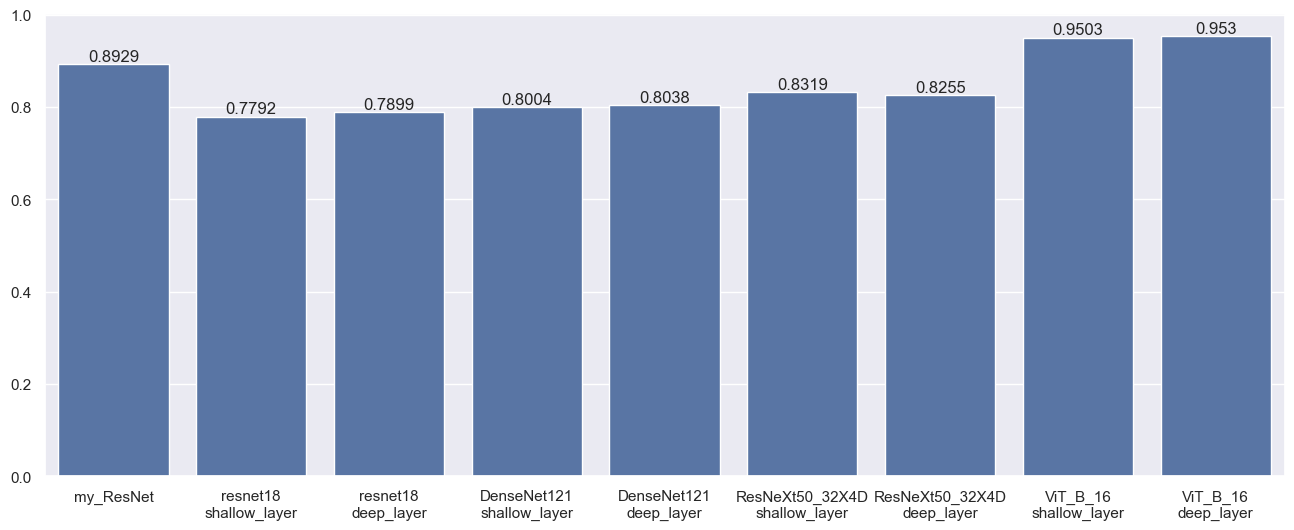

In [37]:
data = { 
    "my_ResNet": 0.8929,

    "resnet18\nshallow_layer": 0.7792,
    "resnet18\ndeep_layer": 0.7899,

    "DenseNet121\nshallow_layer": 0.8004,
    "DenseNet121\ndeep_layer": 0.8038,

    "ResNeXt50_32X4D\nshallow_layer": 0.8319,
    "ResNeXt50_32X4D\ndeep_layer": 0.8255,

    "ViT_B_16\nshallow_layer": 0.9503,
    "ViT_B_16\ndeep_layer": 0.9530,
}


sns.set(rc={'figure.figsize': (16, 6)})

ax = sns.barplot(data=data)

for i in ax.containers:
    ax.bar_label(i,)